# Desarrollo, Entrenamiento y Evaluación de Modelos de Redes Neuronales

En el presente notebook se aborda el desarrollo, entrenamiento y evaluación de modelos basados en redes neuronales.


## 0. Montar Google Drive

Este notebook fue creado y ejecutado en la plataforma Google Colab. Para cargar los datos, se montó Google Drive en el entorno del notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A continuación, se enumeran las librerías que es necesario instalar para ejecutar este notebook en Google Colab.

In [2]:
!pip install tensorflow

## 1. Carga de los Datos

In [3]:
import os
import pandas as pd

# Definimos la ruta base donde están los archivos CSV
ruta_datos = '/content/drive/My Drive/TFG/Datos'
# Preparamos el diccionario para almacenar los DataFrames de cada paciente
datos_pacientes = {}

for i in range(1, 54):
    nombre_archivo = f'811-{i}.csv'
    ruta_archivo = os.path.join(ruta_datos, nombre_archivo)
    try:
        # Cargamos los datos y eliminamos filas con valores ausentes
        df = pd.read_csv(
            ruta_archivo,
            skiprows=2,
            # COLUMNAS DE INTERES
            usecols=[
                'Historial de glucosa mg/dL',
                'Sello de tiempo del dispositivo'
            ]
        ).dropna().copy()

        # Normalizamos los nombres de las columnas para el análisis
        df.rename(columns={
            'Historial de glucosa mg/dL': 'Historial_Glucosa',
            'Sello de tiempo del dispositivo': 'Timestamp'
        }, inplace=True)

        # Almacenamos el DataFrame correspondiente al paciente i
        datos_pacientes[f'paciente{i}'] = df

    except Exception as error:
        print(f"Error al procesar {nombre_archivo}: {error}")


## 2. Preprocesado de Los Datos

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Concatenamos todos los valores de glucosa y creamos un DataFrame con nombre de columna
valores_glucosa = pd.concat(
    [df['Historial_Glucosa'] for df in datos_pacientes.values()]
)

valores_glucosa_df = valores_glucosa.to_frame(name='Historial_Glucosa')

# Ajustamos el scaler usando el DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(valores_glucosa_df)

# Preprocesamos cada paciente usando el scaler ya ajustado
datos_preprocesados = {}
for paciente_id, df in datos_pacientes.items():
    df = df.copy()

    # Convertimos el sello de tiempo y ordenamos las medicione
    df['Timestamp'] = pd.to_datetime(
        df['Timestamp'], dayfirst=True, errors='coerce')

    df = df.sort_values('Timestamp').set_index('Timestamp')

    # Remuestreamos cada 15 minutos y rellenamos huecos por interpolación lineal
    df = (
        df.resample('15min')
          .mean()
          .interpolate(method='linear')
          .reset_index()
    )

    # Normalizamos los valores de glucosa entre 0 y 1
    df['Glucosa_Normalizada'] = scaler.transform(
        df[['Historial_Glucosa']]
    )

    datos_preprocesados[paciente_id] = df

In [5]:
import numpy as np

"""
Creación de las series temporales para entrenar modelos. En este caso para un
horizonte de 15 minutos. (h=1)
"""

# Definimos el mapeo de cada paciente a un índice numérico
claves = list(datos_preprocesados.keys())
mapeo_paciente_indice = {paciente: idx for idx, paciente in enumerate(claves)}

# Inicializamos las listas para secuencias, etiquetas y paciente índice
secuencias, etiquetas, paciente_indices = [], [], []

# Generamos ventanas deslizantes de glucosa por paciente
for paciente, df in datos_preprocesados.items():
    valores_glucosa = df['Historial_Glucosa'].values

    # Para cada bloque de 10 registros, guardamos la secuencia y su etiqueta
    for inicio in range(0, len(valores_glucosa) - 10, 10):
        ventana = valores_glucosa[inicio: inicio + 10]
        objetivo = valores_glucosa[inicio + 10]

        secuencias.append(ventana)
        etiquetas.append(objetivo)
        paciente_indices.append(mapeo_paciente_indice[paciente])

# Convertimos a arrays NumPy con la forma requerida para modelos de series temporales
X_secuencias = np.array(secuencias).reshape(-1, 10, 1)
X_indices_pacientes = np.array(paciente_indices)
y = np.array(etiquetas)

## 3. Creación del modelo

In [6]:
# Definimos los hiperparámetros de nuestro modelo
CONFIG = {
    "learning_rate":    1e-5,
    "batch_size":       512,
    "embedding_dim":    10,
    "num_lstm_layers":  1,
    "lstm_units":       128,
    "lstm_dropout":     0.05,
    "dense_units":      64,
    "dense_dropout":    0.05
}

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding,
    Concatenate, Flatten, Dropout
)
from tensorflow.keras.optimizers import Adam

def build_model(config):
    """
    Construimos un modelo LSTM con embedding del paciente
    para predecir el siguiente valor de glucosa.
    """
    # Creamos la entrada de la serie temporal de glucosa
    entrada_glucosa = Input(shape=(10, 1), name="entrada_glucosa")
    x = entrada_glucosa

    # Añadimos la/s capa/s LSTM según configuración
    for capa in range(config["num_lstm_layers"]):
        return_sequences = (capa < config["num_lstm_layers"] - 1)
        x = LSTM(
            units=config["lstm_units"],
            return_sequences=return_sequences,
            dropout=config["lstm_dropout"]
        )(x)
    salida_lstm = x

    # Creamos la entrada de ID de paciente y su embedding
    entrada_paciente = Input(shape=(1,), name="entrada_paciente")
    emb_paciente = Embedding(
        input_dim=53,
        output_dim=config["embedding_dim"]
    )(entrada_paciente)
    emb_paciente = Flatten()(emb_paciente)

    # Fusionamos la salida LSTM con el embedding del paciente
    fusion = Concatenate()([salida_lstm, emb_paciente])

    # Capas densas para afinar la predicción
    x = Dense(config["dense_units"], activation="relu")(fusion)
    x = Dropout(config["dense_dropout"])(x)
    salida = Dense(1, activation="linear")(x)

    # Compilamos el modelo con MSE y métricas de error
    modelo = Model(
        inputs=[entrada_glucosa, entrada_paciente],
        outputs=salida
    )
    modelo.compile(
        optimizer=Adam(learning_rate=config["learning_rate"]),
        loss="mse",
        metrics=["mae", "mse", "mape"]
    )

    return modelo

# Construimos y mostramos la arquitectura del modelo
model = build_model(CONFIG)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ entrada_paciente    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_glucosa     │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 10)     │        530 │ entrada_paciente… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     66,560 │ entrada_glucosa[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 138)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,051 (297.07 KB)

 Trainable params: 76,051 (297.07 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento

In [8]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en conjuntos de entrenamiento, validación y prueba

# Dividir los datos en TRAIN (80%) y TEST (20%)
X_secuencias_train, X_secuencias_test, X_indices_train, X_indices_test, y_train, y_test = train_test_split(
    X_secuencias, X_indices_pacientes, y, test_size=0.2, random_state=42
)

# Dividir TRAIN en TRAIN (80%) y VALIDATION (20%)
X_secuencias_train, X_secuencias_val, X_indices_train, X_indices_val, y_train, y_val = train_test_split(
    X_secuencias_train, X_indices_train, y_train, test_size=0.2, random_state=42
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

# Definimos rutas para guardar el modelo y el historial de entrenamiento
ruta_base = '/content/drive/My Drive/TFG/Modelos'
ruta_modelo = os.path.join(ruta_base, 'prueba.keras')
ruta_history_csv = os.path.join(ruta_base, 'prueba.csv')
ruta_history_pkl = os.path.join(ruta_base, 'prueba.pkl')

# Mostramos la configuración de hiperparámetros utilizada
print('-' * 30)
print('Configuración de entrenamiento:')
for clave, valor in CONFIG.items():
    print(f'{clave}: {valor}')
print('-' * 30)

# Creamos el callback de detención temprana
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=75,
    restore_best_weights=True,
    verbose=1
)

# Creamos el callback de guardado del mejor modelo
checkpoint = ModelCheckpoint(
    filepath=ruta_modelo,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Entrenamos el modelo usando los conjuntos de entrenamiento y validación
history = model.fit(
    [X_secuencias_train, X_indices_train], y_train,
    validation_data=([X_secuencias_val, X_indices_val], y_val),
    epochs=1500,
    batch_size=CONFIG['batch_size'],
    callbacks=[early_stopping, checkpoint]
)

# Convertimos el historial de entrenamiento a DataFrame y lo guardamos como CSV
df_history = pd.DataFrame(history.history)
df_history.to_csv(ruta_history_csv, index=False)

# Guardamos el objeto history con pickle para análisis posterior
with open(ruta_history_pkl, 'wb') as f:
    pickle.dump(history.history, f)

print('Entrenamiento completado. Modelos e historial guardados.')


------------------------------
Configuración de entrenamiento:
learning_rate: 1e-05
batch_size: 512
embedding_dim: 10
num_lstm_layers: 1
lstm_units: 128
lstm_dropout: 0.05
dense_units: 64
dense_dropout: 0.05
------------------------------
Epoch 1/1500
396/401 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38269.7227 - mae: 179.1485 - mape: 100.4963 - mse: 38269.7227
Epoch 1: val_loss improved from inf to 37718.85938, saving model to /content/drive/My Drive/TFG/Modelos/modelo_tiempo_futuro_1h.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 38264.6406 - mae: 179.1365 - mape: 100.4933 - mse: 38264.6406 - val_loss: 37718.8594 - val_mae: 177.8349 - val_mape: 99.9335 - val_mse: 37718.8594
Epoch 2/1500
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 37775.0781 - mae: 177.8078 - mape: 99.7942 - mse: 37775.0781
Epoch 2: val_loss improved from 37718.85938 to 37422.23047, saving model to /content/drive/My Drive/TFG/Modelos/modelo_tiempo_futuro_1h.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

------------------------------
Configuración de entrenamiento:
learning_rate: 1e-05
batch_size: 512
embedding_dim: 10
num_lstm_layers: 1
lstm_units: 128
lstm_dropout: 0.05
dense_units: 64
dense_dropout: 0.05
------------------------------


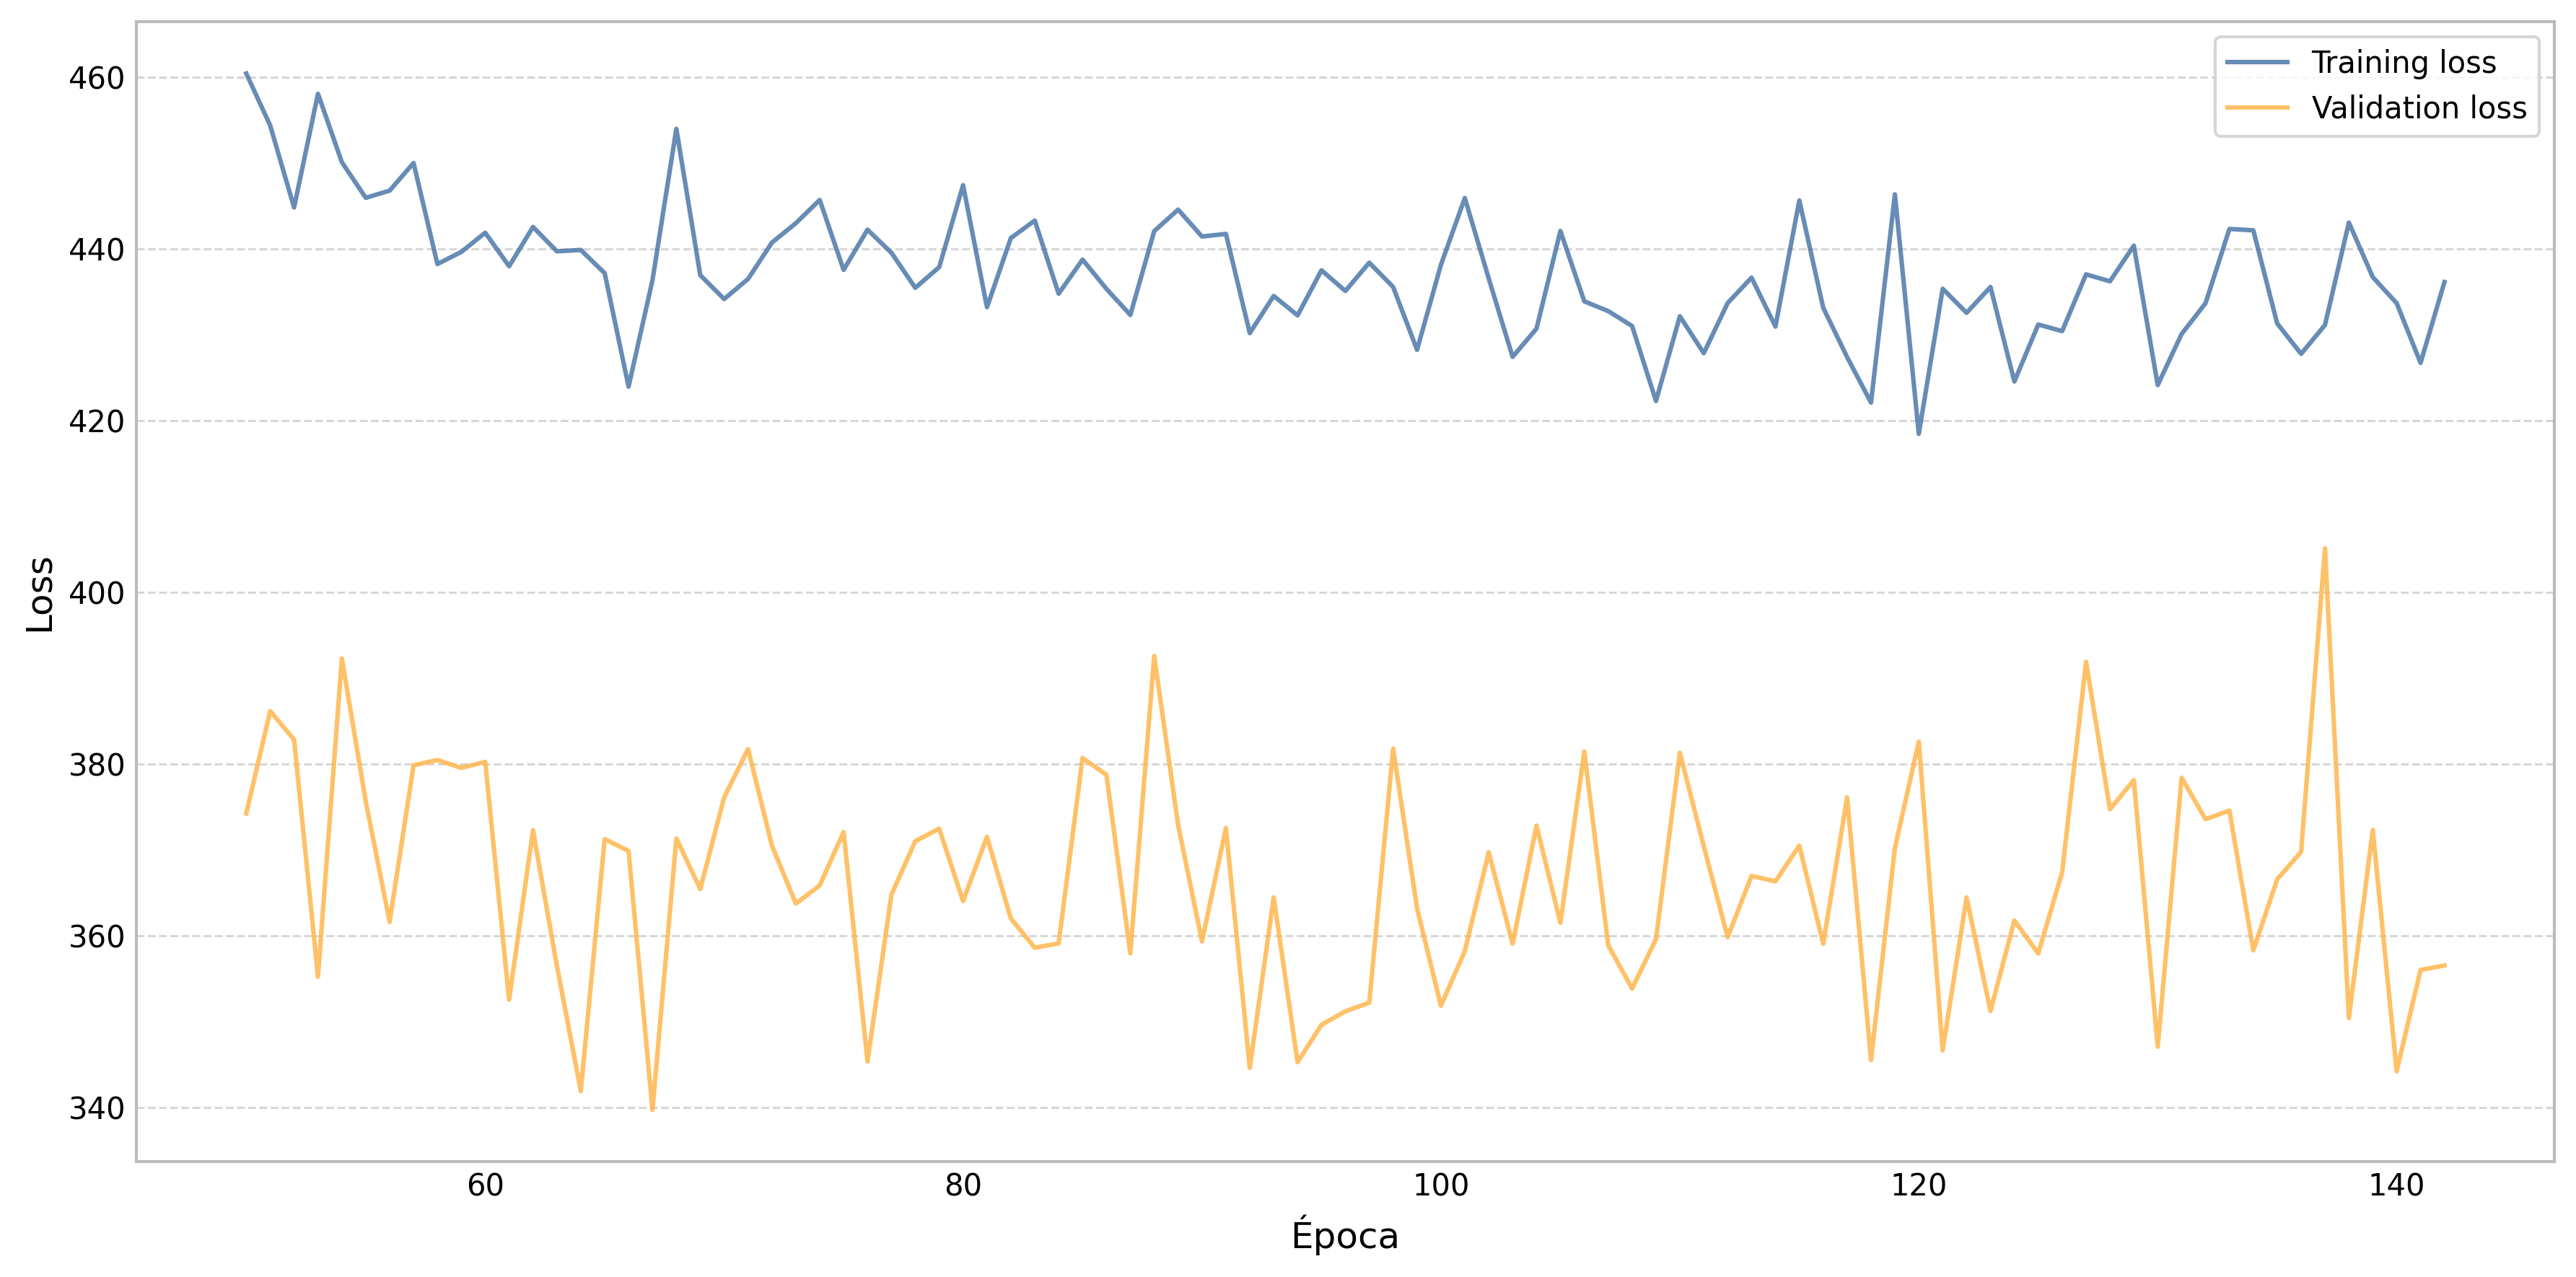

In [14]:
import matplotlib.pyplot as plt

# Mostramos la configuración de entrenamiento
print("-" * 30)
print("Configuración de entrenamiento:")
for clave, valor in CONFIG.items():
    print(f"{clave}: {valor}")
print("-" * 30)

# Seleccionamos las métricas de pérdida a graficar a partir de la época x
x = 80
metricas = ['loss', 'val_loss']
hist = history.history
datos = {m: hist[m][x:] for m in metricas}

# Creamos la figura y el eje con el estilo acordado
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
color_borde = '#BBBBBB'
for borde in ['top', 'bottom', 'left', 'right']:
    ax.spines[borde].set_color(color_borde)
    ax.spines[borde].set_linewidth(1.0)

# Trazamos las curvas de training y validation loss
épocas = range(50, 50 + len(datos['loss']))
ax.plot(
    épocas, datos['loss'],
    label='Training loss',
    color='#4C78A8',
    linewidth=1.5,
    alpha=0.85,
    zorder=2
)
ax.plot(
    épocas, datos['val_loss'],
    label='Validation loss',
    color='#FFB74D',
    linewidth=1.5,
    alpha=0.85,
    zorder=2
)

# Etiquetamos los ejes
ax.set_xlabel('Época', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Configuramos la cuadrícula horizontal
ax.yaxis.grid(
    True,
    color=color_borde,
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)
ax.set_axisbelow(True)

# Ajustamos ticks (sin guiones)
ax.tick_params(axis='both', which='both', length=0, labelsize=10)

# Añadimos la leyenda
ax.legend()

# Ajustamos el layout, guardamos en PDF y mostramos
plt.tight_layout()
plt.savefig('evolucion_loss.pdf')
plt.show()
